# FIGURE 2

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import gmmPLSR_tuning
from msresist.plsr import MeasuredVsPredicted_LOOCVplot, Q2Y_across_components, R2Y_across_components
from msresist.clustering import MyOwnGMM, ClusterAverages
from msresist.sequence_analysis import FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing
from FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

### Importing and Pre-processing Data

### Phosphorylation measurements:

In [2]:
A_r = pd.read_csv('./msresist/data/Raw/20180817_JG_AM_TMT10plex_R1_psms_raw.csv', header=0)
B_r = pd.read_csv('./msresist/data/Raw/20190214_JG_AM_PC9_AXL_TMT10_AC28_R2_PSMs_raw.csv', header=0)
C_r = pd.read_csv('./msresist/data/Raw/CombinedBR3_TR1&2_raw.csv', header=0)

pd.set_option('display.max_colwidth', 1000)

header = A_r.columns
treatments = A_r.columns[2:]

ABC_mc = preprocessing(A_r, B_r, C_r, motifs=True, Vfilter=True, FCfilter=True, log2T=True)

data = ABC_mc.iloc[:,2:].T
protnames = list(ABC_mc.iloc[:,1])
seqs = list(ABC_mc.iloc[:,0])

Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

### Phenotypes

#### Cell Viability:

% Confluency:

In [4]:
Y_cv = pd.read_csv('./msresist/data/Phenotypic_data/CV_raw3.csv').iloc[:30, :11]

Optionally take the fold-change to t=0:

In [5]:
# Y_cv.iloc[:, 1:] = Y_cv.iloc[:, 1:].div(Y_cv.iloc[0, 1:], axis = 1)

Define time-point of interest:

In [6]:
Y_cv = Y_cv[Y_cv["Elapsed"] == 72].iloc[0, 1:11]

# Re-implementation using Gaussian Mixture Model clustering

In [20]:
maxComp = 4

In [21]:
kmeans = MyOwnGMM(maxComp).fit(data, Y_cv)
centers = kmeans.transform(data)

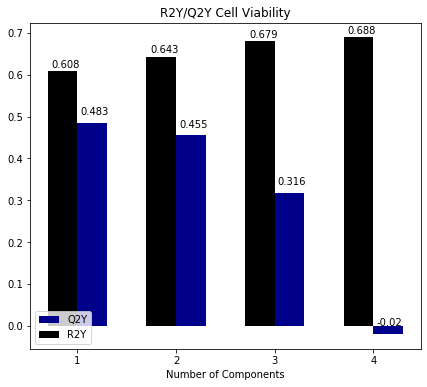

In [22]:
Q2Y = Q2Y_across_components(centers, Y_cv, maxComp+1)
R2Y = R2Y_across_components(centers, Y_cv, maxComp+1)
def truncate(f, n):
    return math.floor(f * 10 ** n) / 10 ** n

def disp_values(x,spac1,spac2,dec):
    for l, m in enumerate(x):
        plt.text(l+spac1,m+spac2,str(truncate(m,dec)))    #change to axs[ax].

range_ = np.linspace(1,maxComp,maxComp)

fig, axs = plt.subplots(1,1,figsize=(7,6))
plt.setp(axs, xticks=range_)
plt.bar(range_+0.15,Q2Y,width=0.3,align='center',label='Q2Y', color = "darkblue")
plt.bar(range_-0.15,R2Y,width=0.3,align='center',label='R2Y', color = "black")
plt.title("R2Y/Q2Y Cell Viability")
plt.xlabel("Number of Components")
plt.legend(loc=3)
disp_values(Q2Y,1.03,0.02,3)
disp_values(R2Y,0.74,0.01,3)

In [11]:
CVresults_max, CVresults_min, best_params = gmmPLSR_tuning(data, Y_cv)
CVresults_min.nlargest(30, "mean_test_scores")

,#ComponentsGMM,#ComponentsPLSR,mean_test_scores,mean_train_scores
35,9,1,-154.632840,-122.416572
6,4,2,-156.880683,-108.404591
54,11,1,-166.783560,-120.502783
2,3,1,-171.095276,-118.305860
10,5,2,-172.846172,-102.174576
44,10,1,-173.927583,-125.435156
7,4,3,-173.944332,-97.275883
45,10,2,-174.244532,-100.412608
5,4,1,-177.743136,-123.585995
20,7,1,-178.784890,-118.733396


In [23]:
ncl, ncomp = 4, 2

In [24]:
gmm_plsr = Pipeline([('gmm', MyOwnGMM(ncl)), ('plsr', PLSRegression(ncomp))])

In [25]:
X_scores, Y_scores = gmm_plsr.fit_transform(data, Y_cv)
PC1_scores, PC2_scores = X_scores[:, 0], X_scores[:, 1]
PC1_xload, PC2_xload = gmm_plsr.named_steps.plsr.x_loadings_[:, 0], gmm_plsr.named_steps.plsr.x_loadings_[:, 1]
PC1_yload, PC2_yload = gmm_plsr.named_steps.plsr.y_loadings_[:, 0], gmm_plsr.named_steps.plsr.y_loadings_[:, 1]

Pearson's R:  0.7228439290443979 
 p-value:  0.018181645156330348


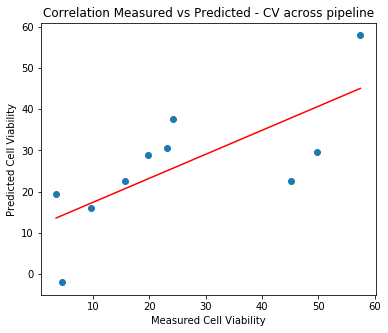

In [26]:
fig, axs = plt.subplots(1,1,figsize=(6,5))
MeasuredVsPredicted_LOOCVplot(data, Y_cv, gmm_plsr, fig, "none", axs)
plt.title("Correlation Measured vs Predicted - CV across pipeline")
plt.xlabel("Measured Cell Viability")
plt.ylabel("Predicted Cell Viability");

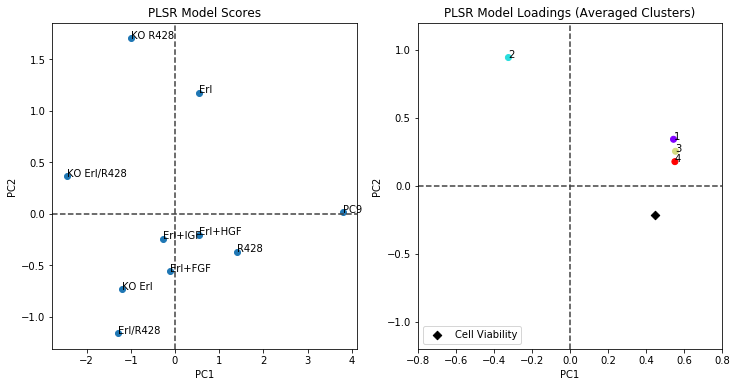

In [27]:
fig, axs = plt.subplots(1, 2,figsize=(12,6))

colors_ = cm.rainbow(np.linspace(0, 1, ncl))


axs[0].scatter(PC1_scores,PC2_scores)
for j, txt in enumerate(treatments):
    axs[0].annotate(txt, (PC1_scores[j], PC2_scores[j]))
axs[0].set_title('PLSR Model Scores')
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].axhline(y=0, color='0.25', linestyle='--')
axs[0].axvline(x=0, color='0.25', linestyle='--')
# axs[0].set_xlim([-3.5, 3.5])
# axs[0].set_ylim([-1, 1])

numbered=[]
list(map(lambda v: numbered.append(str(v+1)), range(ncl)))

for i, txt in enumerate(numbered):
    axs[1].annotate(txt, (PC1_xload[i], PC2_xload[i]))
axs[1].scatter(PC1_xload, PC2_xload, c=np.arange(ncl), cmap=colors.ListedColormap(colors_))
axs[1].scatter(PC1_yload, PC2_yload, color='#000000', marker='D', label='Cell Viability')
axs[1].legend(loc=3)
axs[1].set_title('PLSR Model Loadings (Averaged Clusters)')
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].axhline(y=0, color='0.25', linestyle='--')
axs[1].axvline(x=0, color='0.25', linestyle='--')
axs[1].set_xlim([-0.8, 0.8])
axs[1].set_ylim([-1.2, 1.2]);

In [29]:
clustermembers = gmm_plsr.named_steps.gmm.clustermembers(ABC_mc.T)
clustermembers

,Cluster_1,seqs_Cluster_1,Cluster_2,seqs_Cluster_2,Cluster_3,seqs_Cluster_3,Cluster_4,seqs_Cluster_4
0,"1-phosphatidylinositol 4,5-bisphosphate phosphodiesterase gamma-1",RNPGFyVEANP,Matrin-3,TREPPyRVPRD,Mitogen-activated protein kinase 13,ADAEMtGYVVT,Filamin-B,ESVTRsSTETC
1,MICAL-like protein 1,QADVEyELRCL,Mitogen-activated protein kinase 10,FMMtPyVVTRY,Lysosomal-associated transmembrane protein 4B,EPPPPyVSA,Tyrosine-protein kinase receptor UFO,YNGDYyRQGRI
2,Neuroblast differentiation-associated protein AHNAK,KVKGEyDMTVP,Mitogen-activated protein kinase 11,TGYVAtRWYRA,Myosin light polypeptide 6,GTYEDyVEGLR,Zinc finger CCCH-type antiviral protein 1,LLSSDyRIING
3,Kin of IRRE-like protein 1,SHSSGyAQLNT,Mitogen-activated protein kinase 8,FMMtPyVVTRY,Myosin-9,LDSNLyRIGQS,ERBB receptor feedback inhibitor 1,VSSTHyYLLPE
4,Kinesin light chain 2,AEEVEyYYRRA,Mitotic interactor and substrate of PLK1,YTGQPsPRGLH,Lipoma-preferred partner,NDSDPtYGQQG,BAG family molecular chaperone regulator 3,THQPVyHKIQG
5,Lethal(2) giant larvae protein homolog 1,CFDPYsDDPRL,Mitogen-activated protein kinase 8,FMMTPyVVTRY,Kin of IRRE-like protein 1,SQHSDyGQRFQ,Epidermal growth factor receptor,QDPHStAVGNP
6,Lethal(2) giant larvae protein homolog 1,GCFDPySDDPR,Kinesin-like protein KIF20A,LKRSVyIESRI,LIM and SH3 domain protein 1,ISNIKyHEEFE,Tyrosine-protein kinase receptor UFO,KKETRyGEVFE
7,Lipolysis-stimulated lipoprotein receptor,GGQGSyVPLLR,La-related protein 1,LIVTQtPHYMR,Lethal(2) giant larvae protein homolog 2,SFDPYsDDPRL,Epidermal growth factor receptor,AENAEyLRVAP
8,Lipolysis-stimulated lipoprotein receptor,YAPSTyAHLSP,Plakophilin-2,GNLHRtSSVPE,Paxillin,YCEKDyHNLFS,Epidermal growth factor receptor,SFLQRySSDPT
9,Kin of IRRE-like protein 1,DPTNGyYNVRA,Niban-like protein 1,MDNAVyTFETL,Phosphatidylinositol 3-kinase regulatory subunit alpha,KKLHEyNTQFQ,GRB2-associated-binding protein 1,DERVDyVVVDQ


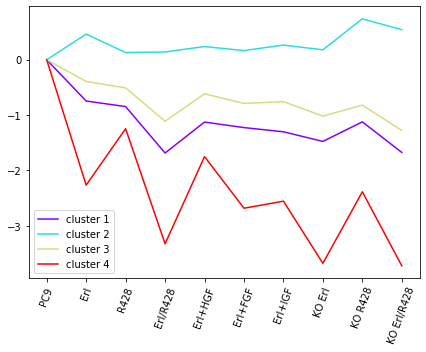

In [30]:
fig = plt.figure(figsize=(7,5))

centers = gmm_plsr.named_steps.gmm.transform(data).T

for i in range(centers.shape[0]):
    plt.plot(centers.iloc[i,:], label = "cluster "+str(i+1), color = colors_[i])
    
plt.legend()
plt.xticks(np.arange(centers.shape[1]), (treatments), rotation=70);

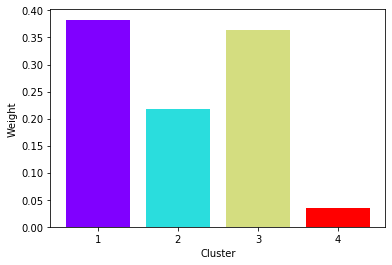

In [31]:
weights = gmm_plsr.named_steps.gmm.weights()

plt.bar(np.linspace(1, weights.size, weights.size), weights, color=colors_);
plt.xticks(np.linspace(1, weights.size, weights.size))
plt.xlabel('Cluster');
plt.ylabel('Weight');